# Plot Per-Class Results from Saved CSV

This notebook loads previously saved results and creates publication-quality plots.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Path setup
REPO_ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir, os.pardir))
RESULTS_DIR = os.path.join(REPO_ROOT, 'PatrickProject', 'Chart_Generation')

# Load the summary CSV
summary_file = os.path.join(RESULTS_DIR, 'class_perclass_summary.csv')
if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    print(f"Loaded data from {summary_file}")
    print(f"Shape: {summary_df.shape}")
    print(summary_df.head())
else:
    print(f"File not found: {summary_file}")
    print("Please run the experiment first to generate the data.")

Loaded data from c:\Users\jbats\Projects\NTU-Synthetic\PatrickProject\Chart_Generation\class_perclass_summary.csv
Shape: (130, 8)
          model          class  mean_accuracy       std        se      ci95  \
0  cvcl-resnext         abacus       0.877333  0.015011  0.008667  0.016987   
1  cvcl-resnext          apple       0.896667  0.016166  0.009333  0.018293   
2  cvcl-resnext            axe       0.876667  0.027154  0.015677  0.030728   
3  cvcl-resnext  babushkadolls       0.870000  0.031177  0.018000  0.035280   
4  cvcl-resnext          bagel       0.811333  0.033606  0.019402  0.038028   

   n_seeds  total_trials  
0        3          1500  
1        3          1500  
2        3          1500  
3        3          1500  
4        3          1500  


In [2]:
# Reconstruct stats_results from CSV
stats_results = {}
models = summary_df['model'].unique()

for model in models:
    stats_results[model] = {}
    model_data = summary_df[summary_df['model'] == model]
    
    for _, row in model_data.iterrows():
        stats_results[model][row['class']] = {
            'mean': row['mean_accuracy'],
            'std': row['std'],
            'se': row['se'],
            'ci95': row['ci95'],
            'n_samples': row['n_seeds'],
            'total_trials': row['total_trials']
        }

models_to_test = list(models)
print(f"Models found: {models_to_test}")
print(f"Number of classes: {len(stats_results[models_to_test[0]])}")

Models found: ['cvcl-resnext', 'clip-res']
Number of classes: 65


C:\Users\jbats\AppData\Local\Temp\ipykernel_17816\3969381298.py:133: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()
C:\Users\jbats\AppData\Local\Temp\ipykernel_17816\3969381298.py:156: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


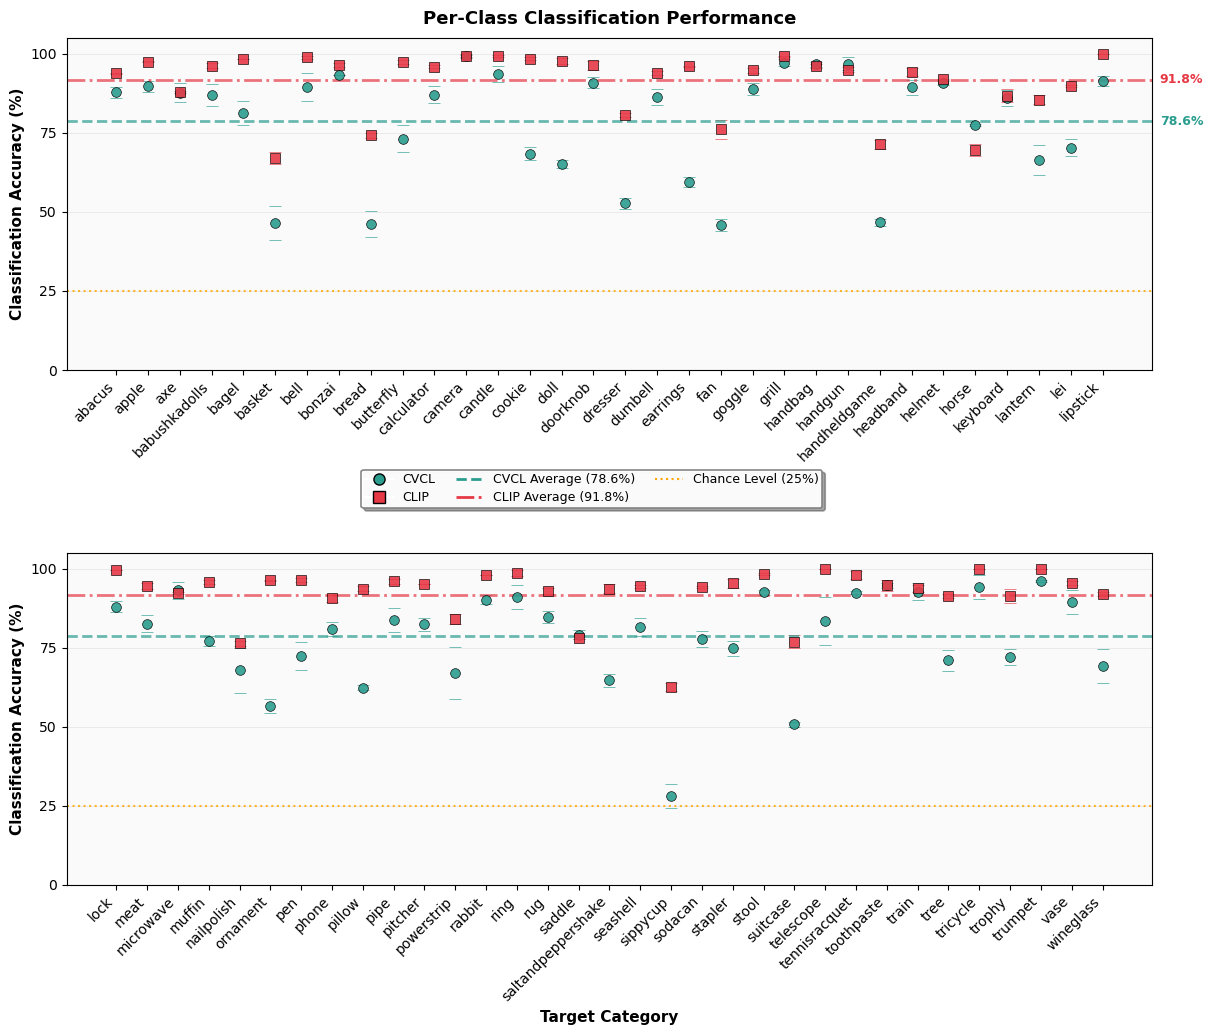

Saved plots from CSV data to:
  - c:\Users\jbats\Projects\NTU-Synthetic\PatrickProject\Chart_Generation\class_perclass_from_csv.png
  - c:\Users\jbats\Projects\NTU-Synthetic\PatrickProject\Chart_Generation\class_perclass_from_csv.pdf


In [13]:
# Create publication-quality visualization with two subplots
fig = plt.figure(figsize=(14, 11))

# Create subplots with space for legend in between
ax1 = plt.subplot2grid((20, 1), (0, 0), rowspan=8)
ax2 = plt.subplot2grid((20, 1), (12, 0), rowspan=8)

# Prepare data for plotting
classes = sorted(list(stats_results[models_to_test[0]].keys()))

# Split classes into two groups
mid_point = len(classes) // 2
classes_first_half = classes[:mid_point]
classes_second_half = classes[mid_point:]

# Define colors and styles
colors = {
    'cvcl-resnext': '#2a9d8f',  # Teal/green color for CVCL
    'clip-res': '#e63946'  # Red color for CLIP
}
markers = {
    'cvcl-resnext': 'o',
    'clip-res': 's'  # Square for CLIP
}
avg_line_styles = {
    'cvcl-resnext': '--',
    'clip-res': '-.'
}

# Short display labels for the legend
short_labels = {
    'cvcl-resnext': 'CVCL',
    'clip-res': 'CLIP'
}


# Store legend elements globally
legend_elements = []

# Function to plot data on an axis
def plot_on_axis(ax, class_subset, is_first=False):
    x_pos = np.arange(len(class_subset))
    
    # Plot each model
    for model_name in models_to_test:
        means = [stats_results[model_name][cls]['mean'] * 100 for cls in class_subset]
        errors = [stats_results[model_name][cls]['ci95'] * 100 for cls in class_subset]
        
        ax.errorbar(x_pos, means, yerr=errors, 
                    label=None,
                    color=colors[model_name],
                    marker=markers[model_name],
                    markersize=7,
                    linewidth=0,
                    capsize=4,
                    capthick=1.5,
                    alpha=0.9,
                    markeredgecolor='black',
                    markeredgewidth=0.5)
    
    # Add chance line
    ax.axhline(y=25, color='#ffa500', linestyle=':', alpha=0.8, linewidth=1.5)
    
    # Calculate and add average lines
    all_classes_means = {}
    for model_name in models_to_test:
        all_means = [stats_results[model_name][cls]['mean'] * 100 for cls in classes]
        all_classes_means[model_name] = np.mean(all_means)
    
    for model_name in models_to_test:
        avg_performance = all_classes_means[model_name]
        ax.axhline(y=avg_performance, 
                  color=colors[model_name], 
                  linestyle=avg_line_styles[model_name], 
                  alpha=0.7, 
                  linewidth=2)
        
        if is_first:
            ax.text(len(class_subset) + 0.8, avg_performance, 
                   f'{avg_performance:.1f}%', 
                   fontsize=9, 
                   color=colors[model_name], 
                   va='center',
                   fontweight='bold')
    
    # Formatting
    ax.set_ylabel('Classification Accuracy (%)', fontsize=11, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(class_subset, rotation=45, ha='right', fontsize=10)
    ax.set_ylim(0, 105)
    ax.set_yticks([0, 25, 50, 75, 100])
    ax.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    ax.set_facecolor('#fafafa')
    
    # Create legend elements (only once)
    global legend_elements
    if is_first:
        from matplotlib.lines import Line2D
        legend_elements = []
        
        for model_name in models_to_test:
            legend_elements.append(
                Line2D([0], [0], marker=markers[model_name], color='w', 
                      markerfacecolor=colors[model_name], markeredgecolor='black',
                      markersize=8, label=short_labels[model_name])
            )
        
        for model_name in models_to_test:
            avg_val = all_classes_means[model_name]
            legend_elements.append(
                Line2D([0], [0], color=colors[model_name], 
                      linestyle=avg_line_styles[model_name], linewidth=2,
                      label=f'{model_name.upper().split("-")[0]} Average ({avg_val:.1f}%)')
            )
        
        legend_elements.append(
            Line2D([0], [0], color='#ffa500', linestyle=':', linewidth=1.5,
                  label='Chance Level (25%)')
        )

# Plot both halves
plot_on_axis(ax1, classes_first_half, is_first=True)
ax1.set_title('Per-Class Classification Performance', 
              fontsize=13, fontweight='bold', pad=10)

plot_on_axis(ax2, classes_second_half, is_first=False)

ax2.set_xlabel('Target Category', fontsize=11, fontweight='bold')


# --- Legend centered between subplots (smaller, no overlap) ---
plt.tight_layout()
plt.subplots_adjust(hspace=0.35)  # keep your spacing between the two axes

legend = fig.legend(
    handles=legend_elements,
    loc='center',
    bbox_to_anchor=(0.5, 0.47),   # (x, y) in figure coords; tweak y ~0.49–0.52
    ncol=3,
    fontsize=9,
    frameon=True,
    fancybox=True,
    shadow=True,
    framealpha=0.95,
    borderpad=0.3,                # tighter box padding
    labelspacing=0.4,             # tighter line spacing
    handlelength=2.2,
    columnspacing=1.6
)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('gray')
legend.get_frame().set_linewidth(1.2)


plt.tight_layout()
plt.subplots_adjust(hspace=0.35)

plt.savefig(os.path.join(RESULTS_DIR, 'class_perclass_from_csv.png'), dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig(os.path.join(RESULTS_DIR, 'class_perclass_from_csv.pdf'), bbox_inches='tight', facecolor='white')
plt.show()

print(f"Saved plots from CSV data to:")
print(f"  - {os.path.join(RESULTS_DIR, 'class_perclass_from_csv.png')}")
print(f"  - {os.path.join(RESULTS_DIR, 'class_perclass_from_csv.pdf')}")